In [1]:
import sys
sys.version

'3.6.4 |Anaconda custom (64-bit)| (default, Mar 12 2018, 20:20:50) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import loadtxt, e, where, zeros, exp, array, log, ones, append, linspace, reshape, transpose
from pylab import scatter, show, legend, xlabel, ylabel, contour, title
from scipy.optimize import fmin_bfgs
from numpy import loadtxt, where
from pylab import scatter, show, legend, xlabel, ylabel
import cython
import numpy as np
from sklearn import preprocessing
from scipy.special import expit
from sklearn.preprocessing import StandardScaler

In [3]:
dirlocation=''
file1='ex2data1.txt'
file2='ex2data2.txt'
file1labels=['Exam 1 score','Exam 2 score']
file1legend=['Not Admitted', 'Admitted']
file2labels=['Microchip Test 1','Microchip Test 1']
file2legend=['passed', 'failed'] # for scatterplot only
dirlocation+file1

'ex2data1.txt'

In [4]:
# %%writefile sigmoid.py
from scipy.special import expit
def sigmoid(X):
    from scipy.special import expit
    return expit(X)

In [5]:
# from sigmoid import sigmoid

In [6]:
sigmoid([5])

array([ 0.99330715])

In [7]:
def show_scatter(data, intitle,  labels=file1labels,inlegend=file1legend):
    X = data[:, 0:2]
    y = data[:, 2]
    pos = where(y == 1)
    neg = where(y == 0)
    scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
    scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
    xlabel(labels[0])
    ylabel(labels[1])
    title(intitle)
    legend(inlegend)
    show()
    return None
def load_dataset(filename=file1, labels=file1labels, inlegend=file1legend,intitle='Data Set', show_sc=False):
    data = loadtxt(dirlocation+filename, delimiter=',')
    if show_sc:
        show_scatter(data,  intitle=intitle,labels=labels,inlegend=inlegend)
    return data

In [8]:
e**2

7.3890560989306495

In [9]:
def compute_cost(theta,X,y): #computes cost given predicted and actual values
    m = X.shape[0] #number of training examples
    theta = reshape(theta,(len(theta),1))

    #y = reshape(y,(len(y),1))
    
    J = (1./m) * (-transpose(y).dot(log(sigmoid(X.dot(theta)))) - transpose(1-y).dot(log(1-sigmoid(X.dot(theta)))))
    
    grad = transpose((1./m)*transpose(sigmoid(X.dot(theta)) - y).dot(X))
    #optimize.fmin expects a single value, so cannot return grad
    return J[0][0], grad #,grad

In [10]:
def compute_grad(theta, X, y):

    #print theta.shape

    theta.shape = (1, 3)

    grad = zeros(3)

    h = sigmoid(X.dot(theta.T))

    delta = h - y

    l = grad.size

    for i in range(l):
        sumdelta = delta.T.dot(X[:, i])
        grad[i] = (1.0 / m) * sumdelta * - 1

    theta.shape = (3,)

    return  grad

In [11]:
def predict(theta, X_unscaled, scaler, interaction=False, degree=6):
    '''Predict whether the label
    is 0 or 1 using learned logistic
    regression parameters '''
#     X=preprocessing(X_unscaled)
#     X_scaled=(X_unscaled-xmean)/xstd
    X_scaled = scaler.transform(X_unscaled)
#     X=map_feature(X_scaled, degree=degree)
    if interaction:
        X=map_feature(X_scaled[:,0], X_scaled[:,1])
    else: 
        X=X_scaled
    m, n = X.shape
    p = zeros(shape=(m, 1))
    theta = reshape(theta,(28,1))
    h = sigmoid(X.dot(theta))

    for it in range(0, h.shape[0]):
        if h[it] > 0.5:
            p[it, 0] = 1
        else:
            p[it, 0] = 0

    return p

In [12]:
def cost_function_reg(theta, X, y, plambda=1):
    '''Compute the cost and partial derivatives as grads
    '''
    m=X.shape[0]
    h = sigmoid(X.dot(theta))
    assert h.shape[0]==y.shape[0]
    assert h.shape[1]==y.shape[1]
#     theta = reshape(theta,(len(theta),1))
    thetaR = theta[1:, 0]
    J = (1.0 / m) * ((-y.T.dot(log(h))) - ((1 - y.T).dot(log(1.0 - h)))) \
            + (plambda / (2.0 * m)) * (thetaR.T.dot(thetaR))

    delta = h - y
    sumdelta = delta.T.dot(X[:, 1])
    grad1 = (1.0 / m) * sumdelta

    XR = X[:, 1:X.shape[1]]
    sumdelta = delta.T.dot(XR)

    grad = (1.0 / m) * (sumdelta + plambda * thetaR)

    out = zeros(shape=(grad.shape[0], grad.shape[1] + 1))

    out[:, 0] = grad1
    out[:, 1:] = grad

    return J.flatten(), out.T.flatten()
#####################################################################################################


In [13]:
def decorated_cost(theta):
    return cost_function_reg(theta, it, y, 1)[0]

In [14]:
# from cost_function_reg import cost_function_reg
# from decorated_cost import decorated_cost

In [15]:
def get_combs(n, m):
    from itertools import combinations
    """Generate combinations of n identical items in m boxes.
    list(get_combs)(4, 2))
    [(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]
    """
    for c in combinations(range(n + m - 1), m - 1):
        yield tuple(b - a - 1 for a, b in zip((-1,) + c, c + (n + m - 1,)))

In [16]:
def map_feature2degree(X, degree=6):
    '''
    Maps the m input features to given degree.
    Returns a new feature array with more features, comprising of
    X1**degree,X1**(degree-1)*X2 etc...
    Inputs X1, X2,..., Xn must be the same size
    '''
    num_obs, num_features=X.shape
    out = zeros(shape=(num_obs, 1))
   
    comb_list = get_combs(degree,num_features)
    for jlist in comb_list:
        powered_and_multed=np.prod(X**jlist, axis=1)
        aaa=powered_and_multed.reshape(num_obs,1)
#         print (aaa.shape)
#         powered_and_multed.reshape(num_obs,1)
        bbb=append(out, aaa, axis=1)
        out=bbb      
#         print (out.shape)    
    return out

In [17]:
# %%writefile map_feature.py
def map_feature(x1, x2):
    '''
    Maps the two input features to quadratic features.
    Returns a new feature array with more features, comprising of
    X1, X2, X1 ** 2, X2 ** 2, X1*X2, X1*X2 ** 2, etc...
    Inputs X1, X2 must be the same size
    '''
    x1.shape = (x1.size, 1)
    x2.shape = (x2.size, 1)
    degree = 6
    out = ones(shape=(x1[:, 0].size, 1))

    m, n = out.shape

    for i in range(1, degree + 1):
        for j in range(i + 1):
            r = (x1 ** (i - j)) * (x2 ** j)
            out = append(out, r, axis=1)

    return out

In [18]:
# from map_feature import map_feature

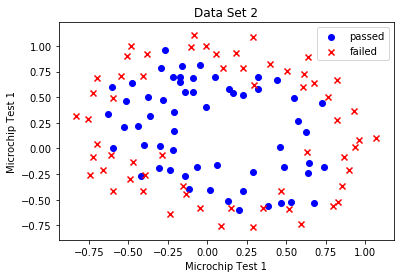

In [19]:
#Load Dataset 2 and show scatterplot
data2 = load_dataset(file2, labels=file2labels, inlegend=file2legend,intitle='Data Set 2', show_sc=False)
show_scatter(data2,intitle='Data Set 2',labels=file2labels, inlegend=file2legend)


##  Regularization and Accuracy
#### Moving to Data Set 2 and Implementing Regularization and Calculating Accuracy

In [20]:
data2=load_dataset(file2, labels=file2labels, inlegend=file2legend,intitle='Data Set 2', show_sc=False)
#Working with dataset 2
degree=6 # Dealing with 6th order inetractions
num_obs, num_features = data2.shape
X = data2[:, 0:num_features-1]
y = data2[:, num_features-1]
# X_scaled=preprocessing.scale(X)
scaler2 = preprocessing.StandardScaler().fit(X)
X_mean=X.mean(axis=0)
X_std=X.std(axis=0)
m, n = X.shape
y.shape = (num_obs, 1)
X_scaled=scaler2.transform(X)
# it = map_feature2degree(X_scaled,degree)
it=map_feature(X_scaled[:,0], X_scaled[:,1])
#Initialize theta parameters
l=1 # Initial Lambda
initial_theta = zeros(shape=(it.shape[1], l))
cost, grad = cost_function_reg(initial_theta, it, y, 0.2)
print ('cost is: ', cost) 
print( 'gradient is: ', grad)

cost is:  [ 0.69314718]
gradient is:  [ 0.03705198  0.03705198 -0.00284799  0.19753354  0.03181133  0.14157707
  0.08474569 -0.02197759  0.01912472  0.01978675  0.60552761 -0.01178425
  0.17516318 -0.00748334  0.41389202  0.32662613 -0.08620202  0.03911234
 -0.02213139  0.05549666  0.01571     1.78985126 -0.11770386  0.34722535
 -0.07226827  0.2933989  -0.11751531  1.15773589]


#### Regularized Function minimization and calculation of associated theta values for Data Set 2

In [21]:
# Implement Batch sgd
# The function does not standardize the data, that control remains with the calling function
def batch_sgd(X,y,theta,learning_rate,max_iters=400,tolerance=1e-3, plambda=0.01, batchsize=3, X_orig=X,\
              tolcheck=True, get_accuracy=True):
    grad=[]
    cost=[]
    xmean=X.mean()
    xstd=X.std()
    y.shape=(len(y),1)
    for i in range(max_iters):
        random_batch=np.random.choice(np.arange(X.shape[0]), batchsize, replace=False)
        x_random_batch=X[random_batch,:]
        y_random_batch=y[random_batch,:]
        assert x_random_batch.shape[0]==y_random_batch.shape[0]
        assert x_random_batch.shape[1]==theta.shape[0]
        h = sigmoid(x_random_batch.dot(theta))
        delta = h - y_random_batch
    #     print ("delta shape", delta.shape)
    #     print (delta.T.dot(x_random_batch).shape)
        theta=theta*(1-learning_rate*plambda/batchsize)-learning_rate*(1.0/batchsize)*delta.T.dot(x_random_batch).T
#         print("theta shape:\n", theta.shape)
        cost.append(cost_function_reg(theta, X, y, plambda)[0])
        p=predict(array(theta),X_orig , scaler2, interaction=True)
        if get_accuracy:
            accuracy.append((y[where(p == y)].size / float(y.size)) )
        if tolcheck:
            if i%100==0 & i>100:
                if abs(sum(cost[i-6:i])-sum(cost[i-12:i-6]))<tolerance*600:
                    print ("convergence achieved at iteration number\n :", i)
                    return theta, cost
#     gradsize = grad.size
#     for i in range(gradsize):
#         sumdelta = delta.T.dot(X[:, i])
#         grad[i] = (1.0 / m) * sumdelta * - 1
#     theta.shape = (3,)

    return  theta, cost # J is teh cost function

In [22]:
it.dot(initial_theta).size
initial_theta.shape
it.shape
# theta.shape

(118, 28)

#### Mini Batch SGD - Cost Function and Accuracy against learning rates
The cost function and the associated accuracy have been plotted for 6 learning rates as below. We can see that the cost function becomes noisier as the learning rate increases above 0.01


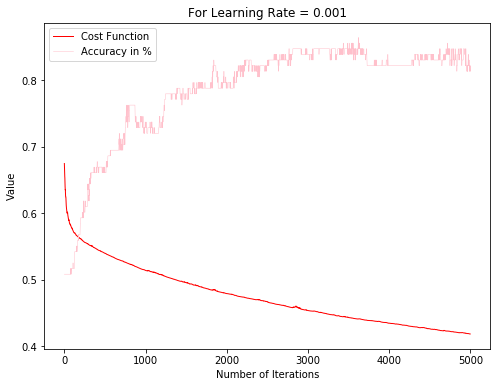

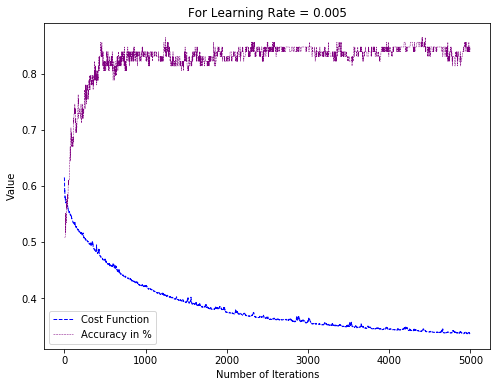

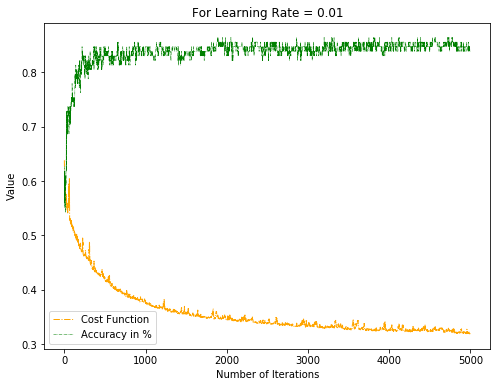

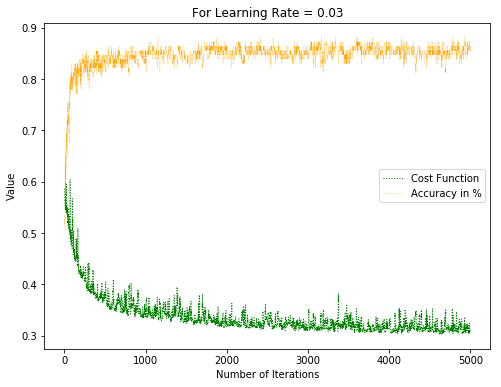

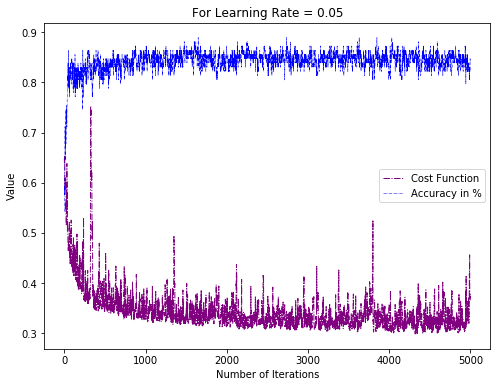

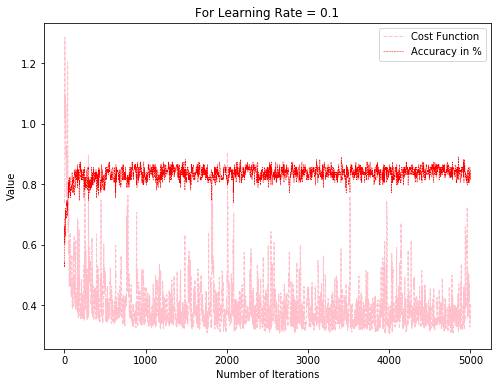

In [23]:
# %%timeit
accuracy=[]
# inlearnrates=[0.01]
inlearnrates=[0.001,0.005,0.01,0.03, 0.05,0.1]
colordata=['red','blue','orange','green','purple','pink']
linestyles = ['-', '--', '-.', ':', '-.', '--']
# plt.figure(figsize=(20,10))
for i in range(len(inlearnrates)):
    accuracy=[]
    theta, J = batch_sgd(it,y,initial_theta,max_iters=5000, learning_rate=inlearnrates[i], batchsize=5,\
                         plambda=1e-2, tolcheck=True)
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(J)-1), J[1:], lw=1, color=colordata[i], linestyle=linestyles[i])
    plt.plot(np.arange(len(accuracy)-1), accuracy[1:], lw=0.5, color=colordata[len(colordata)-i-1], linestyle=linestyles[i])
    legend(['Cost Function', 'Accuracy in %'])
    xlabel('Number of Iterations')
    ylabel("Value")
    plot_title='For Learning Rate = ' + str(inlearnrates[i])
    title(plot_title)
    plt.show()




#### We now profile the batch sgd for the best value of the learning rate


In [24]:
%timeit theta, J = batch_sgd(it,y,initial_theta,max_iters=5000, learning_rate=0.01, batchsize=5,\
                     plambda=1e-2, tolcheck=False, get_accuracy=True)

6.07 s ± 844 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


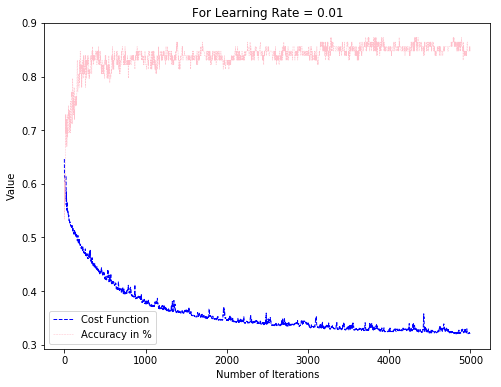

In [25]:
accuracy=[]
colordata=['red','blue','orange','green','purple','pink']
linestyles = ['-', '--', '-.', ':', '-.', '--']
theta, J = batch_sgd(it,y,initial_theta,max_iters=5000, learning_rate=0.01, batchsize=5,\
                     plambda=1e-2, tolcheck=False, get_accuracy=True)
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(J)-1), J[1:], lw=1, color=colordata[1], linestyle=linestyles[1])
plt.plot(np.arange(len(accuracy)-1), accuracy[1:], lw=0.5, color=colordata[len(colordata)-1], linestyle=linestyles[1])
legend(['Cost Function', 'Accuracy in %'])
xlabel('Number of Iterations')
ylabel("Value")
plot_title='For Learning Rate = ' + str(inlearnrates[2])
title(plot_title)
plt.show()

In [26]:
len(accuracy)

5000

#### Predicted Accuracy with default Lambda on the Training Set for Data Set 2

In [27]:
p=predict(array(theta), X, scaler2, interaction=True)
print ('Training Accuracy  With Regularization Is: %f' % ((y[where(p == y)].size / float(y.size)) * 100.0))


Training Accuracy  With Regularization Is: 84.745763


##### Plot the decision boundary

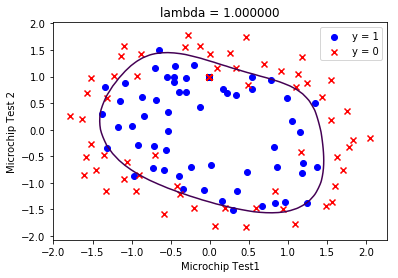

In [28]:
## First we draw the scatterplot for the dataset 2
#Plot Boundary
labels=file2labels
inlegend=file2legend
intitle='Data Set 2'
# X = data2[:, 0:2]
# y = data2[:, 2]
pos = where(y == 1)
neg = where(y == 0)
scatter(X_scaled[pos, 0], X_scaled[pos, 1], marker='o', c='b')
scatter(X_scaled[neg, 0], X_scaled[neg, 1], marker='x', c='r')
xlabel(labels[0])
ylabel(labels[1])
title(intitle)
legend(inlegend)
u = linspace(min(X_scaled[:,0]), max(X_scaled[:,0]), 50)
v = linspace(min(X_scaled[:,1]), max(X_scaled[:,1]), 50)
z = zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = (map_feature(array(u[i]), array(v[j])).dot(array(theta)))

z = z.T
# z=scaler2.inverse_transform(z)
contour(u, v, z, levels=[0])
title('lambda = %f' % l)
xlabel('Microchip Test1')
ylabel('Microchip Test 2')
legend(['y = 1', 'y = 0', 'Decision boundary'])
show()